In [1]:
# Import our dependencies
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import hvplot.pandas
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf

from pyspark.sql import SparkSession
import time


# decision tree visualization imports
import pydotplus
from IPython.display import Image

2023-11-15 18:03:00.561844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading and Preprocessing Data

In [2]:
# Import dataset
health_df = pd.read_csv('../Final-Project/Data/heart_data2022.csv')
health_df.head()


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [3]:
#Clean Data
health_df = health_df.dropna()

#Make Boolean Columns or Numeric values for the columns
health_df['HeartDisease'] = (health_df["HadHeartAttack"] == 'Yes')
health_df['HeartDisease'] = health_df['HeartDisease'].astype(int)

health_df = health_df.drop(['State', 'Sex','LastCheckupTime','HadHeartAttack','RemovedTeeth','SmokerStatus','ECigaretteUsage','RaceEthnicityCategory','AgeCategory','TetanusLast10Tdap'], axis=1)


health_df

,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos,HeartDisease
342,Very good,4.0,0.0,Yes,9.0,No,No,No,No,No,...,1.60,71.67,27.99,No,No,Yes,Yes,No,No,0
343,Very good,0.0,0.0,Yes,6.0,No,No,No,No,No,...,1.78,95.25,30.13,No,No,Yes,Yes,No,No,0
345,Very good,0.0,0.0,No,8.0,No,No,No,No,No,...,1.85,108.86,31.66,Yes,No,No,Yes,No,Yes,0
346,Fair,5.0,0.0,Yes,9.0,No,No,No,Yes,No,...,1.70,90.72,31.32,No,No,Yes,Yes,No,Yes,0
347,Good,3.0,15.0,Yes,5.0,No,No,No,No,No,...,1.55,79.38,33.07,No,No,Yes,Yes,No,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445117,Very good,0.0,0.0,Yes,6.0,No,No,No,No,No,...,1.78,102.06,32.28,Yes,No,No,No,No,No,0
445123,Fair,0.0,7.0,Yes,7.0,No,No,No,No,No,...,1.93,90.72,24.34,No,No,No,No,No,Yes,0
445124,Good,0.0,15.0,Yes,7.0,No,Yes,No,No,No,...,1.68,83.91,29.86,Yes,Yes,Yes,Yes,No,Yes,0
445128,Excellent,2.0,2.0,Yes,7.0,No,No,No,No,No,...,1.70,83.01,28.66,No,Yes,Yes,No,No,No,0


In [4]:

health_df = health_df.reset_index(drop=True)

In [5]:
booleanCols = ['PhysicalActivities', 'AlcoholDrinkers','HIVTesting','FluVaxLast12','PneumoVaxEver','HighRiskLastYear','CovidPos','HadAngina','HadStroke','HadAsthma','HadSkinCancer','HadCOPD','HadDepressiveDisorder','HadKidneyDisease','HadArthritis','HadDiabetes','DeafOrHardOfHearing','BlindOrVisionDifficulty','DifficultyConcentrating','DifficultyWalking','DifficultyDressingBathing','DifficultyErrands','ChestScan']

#health_df.reset_index()

In [6]:
health_df['GeneralHealth']

for col in booleanCols:
    health_df[col] = (health_df[col] == 'Yes')
    health_df[col] = health_df[col].astype(int)
    
health_df

,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos,HeartDisease
0,Very good,4.0,0.0,1,9.0,0,0,0,0,0,...,1.60,71.67,27.99,0,0,1,1,0,0,0
1,Very good,0.0,0.0,1,6.0,0,0,0,0,0,...,1.78,95.25,30.13,0,0,1,1,0,0,0
2,Very good,0.0,0.0,0,8.0,0,0,0,0,0,...,1.85,108.86,31.66,1,0,0,1,0,1,0
3,Fair,5.0,0.0,1,9.0,0,0,0,1,0,...,1.70,90.72,31.32,0,0,1,1,0,1,0
4,Good,3.0,15.0,1,5.0,0,0,0,0,0,...,1.55,79.38,33.07,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,Very good,0.0,0.0,1,6.0,0,0,0,0,0,...,1.78,102.06,32.28,1,0,0,0,0,0,0
246018,Fair,0.0,7.0,1,7.0,0,0,0,0,0,...,1.93,90.72,24.34,0,0,0,0,0,1,0
246019,Good,0.0,15.0,1,7.0,0,1,0,0,0,...,1.68,83.91,29.86,1,1,1,1,0,1,0
246020,Excellent,2.0,2.0,1,7.0,0,0,0,0,0,...,1.70,83.01,28.66,0,1,1,0,0,0,0


In [7]:
for i in range(len(health_df['GeneralHealth'])):
    if health_df['GeneralHealth'][i] == 'Very good':
        health_df.at[i, 'GeneralHealth'] = 4
    elif health_df['GeneralHealth'][i] == 'Good':
        health_df.at[i, 'GeneralHealth'] = 3
    elif health_df['GeneralHealth'][i] == 'Fair':
        health_df.at[i, 'GeneralHealth'] = 2
    elif health_df['GeneralHealth'][i] == 'Excellent':
        health_df.at[i, 'GeneralHealth'] = 5
    elif health_df['GeneralHealth'][i] == 'Poor':
        health_df.at[i, 'GeneralHealth'] = 1

In [8]:
health_df['GeneralHealth'] = health_df['GeneralHealth'].astype(int)
    
health_df

,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos,HeartDisease
0,4,4.0,0.0,1,9.0,0,0,0,0,0,...,1.60,71.67,27.99,0,0,1,1,0,0,0
1,4,0.0,0.0,1,6.0,0,0,0,0,0,...,1.78,95.25,30.13,0,0,1,1,0,0,0
2,4,0.0,0.0,0,8.0,0,0,0,0,0,...,1.85,108.86,31.66,1,0,0,1,0,1,0
3,2,5.0,0.0,1,9.0,0,0,0,1,0,...,1.70,90.72,31.32,0,0,1,1,0,1,0
4,3,3.0,15.0,1,5.0,0,0,0,0,0,...,1.55,79.38,33.07,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246017,4,0.0,0.0,1,6.0,0,0,0,0,0,...,1.78,102.06,32.28,1,0,0,0,0,0,0
246018,2,0.0,7.0,1,7.0,0,0,0,0,0,...,1.93,90.72,24.34,0,0,0,0,0,1,0
246019,3,0.0,15.0,1,7.0,0,1,0,0,0,...,1.68,83.91,29.86,1,1,1,1,0,1,0
246020,5,2.0,2.0,1,7.0,0,0,0,0,0,...,1.70,83.01,28.66,0,1,1,0,0,0,0


In [9]:
health_df.dtypes


GeneralHealth                  int64
PhysicalHealthDays           float64
MentalHealthDays             float64
PhysicalActivities             int64
SleepHours                   float64
HadAngina                      int64
HadStroke                      int64
HadAsthma                      int64
HadSkinCancer                  int64
HadCOPD                        int64
HadDepressiveDisorder          int64
HadKidneyDisease               int64
HadArthritis                   int64
HadDiabetes                    int64
DeafOrHardOfHearing            int64
BlindOrVisionDifficulty        int64
DifficultyConcentrating        int64
DifficultyWalking              int64
DifficultyDressingBathing      int64
DifficultyErrands              int64
ChestScan                      int64
HeightInMeters               float64
WeightInKilograms            float64
BMI                          float64
AlcoholDrinkers                int64
HIVTesting                     int64
FluVaxLast12                   int64
P

In [10]:

cleanHealth_df = health_df.drop(columns="HeartDisease")
cleanHealth_df.head()


,GeneralHealth,PhysicalHealthDays,MentalHealthDays,PhysicalActivities,SleepHours,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,...,ChestScan,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,HighRiskLastYear,CovidPos
0,4,4.0,0.0,1,9.0,0,0,0,0,0,...,0,1.60,71.67,27.99,0,0,1,1,0,0
1,4,0.0,0.0,1,6.0,0,0,0,0,0,...,0,1.78,95.25,30.13,0,0,1,1,0,0
2,4,0.0,0.0,0,8.0,0,0,0,0,0,...,1,1.85,108.86,31.66,1,0,0,1,0,1
3,2,5.0,0.0,1,9.0,0,0,0,1,0,...,0,1.70,90.72,31.32,0,0,1,1,0,1
4,3,3.0,15.0,1,5.0,0,0,0,0,0,...,0,1.55,79.38,33.07,0,0,1,1,0,0


In [11]:
# Remove HeartDisease target from features data
y = health_df.HeartDisease.values
X = health_df.drop(columns="HeartDisease").values

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

X_train

array([[ 2., 15.,  0., ...,  0.,  0.,  1.],
       [ 2.,  0.,  7., ...,  0.,  0.,  1.],
       [ 4.,  0.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 4.,  0.,  0., ...,  0.,  0.,  1.],
       [ 4.,  2.,  0., ...,  1.,  0.,  0.],
       [ 5.,  0.,  0., ...,  0.,  0.,  0.]])

In [12]:
# Preprocess numerical data for neural network

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [13]:

## Deep Learning Model

## Deep Learning Model

In [14]:
# Define the deep learning model 
nn_model = tf.keras.models.Sequential()
nn_model.add(tf.keras.layers.Dense(units=16, activation="relu", input_dim=30))  # Adjusted input_dim to match the number of features after querying data
nn_model.add(tf.keras.layers.Dense(units=16, activation="relu"))
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=50)
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
5767/5767 [==============================] - 16s 3ms/step - loss: 0.1583 - accuracy: 0.9456
Epoch 2/50
5767/5767 [==============================] - 16s 3ms/step - loss: 0.1477 - accuracy: 0.9477
Epoch 3/50
5767/5767 [==============================] - 17s 3ms/step - loss: 0.1470 - accuracy: 0.9479
Epoch 4/50
5767/5767 [==============================] - 16s 3ms/step - loss: 0.1466 - accuracy: 0.9482
Epoch 5/50
5767/5767 [==============================] - 20s 3ms/step - loss: 0.1464 - accuracy: 0.9484
Epoch 6/50
5767/5767 [==============================] - 22s 4ms/step - loss: 0.1461 - accuracy: 0.9482
Epoch 7/50
5767/5767 [==============================] - 18s 3ms/step - loss: 0.1461 - accuracy: 0.9483
Epoch 8/50
5767/5767 [==============================] - 17s 3ms/step - loss: 0.1460 - accuracy: 0.9484
Epoch 9/50
5767/5767 [==============================] - 17s 3ms/step - loss: 0.1460 - accuracy: 0.9485
Epoch 10/50
5767/5767 [==============================] - 16s 3ms/step - l

## Fitting the Decision Tree Model

In [16]:
# Decision tree classifier instance and fit the model
model = tree.DecisionTreeClassifier(max_depth=5, random_state=1)
model = model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [17]:
## Evaluating and Visualizing Decision Tree Model


In [18]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,57626,521
Actual 1,2775,584


Accuracy Score : 0.9464117321887295
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     58147
           1       0.53      0.17      0.26      3359

    accuracy                           0.95     61506
   macro avg       0.74      0.58      0.62     61506
weighted avg       0.93      0.95      0.93     61506



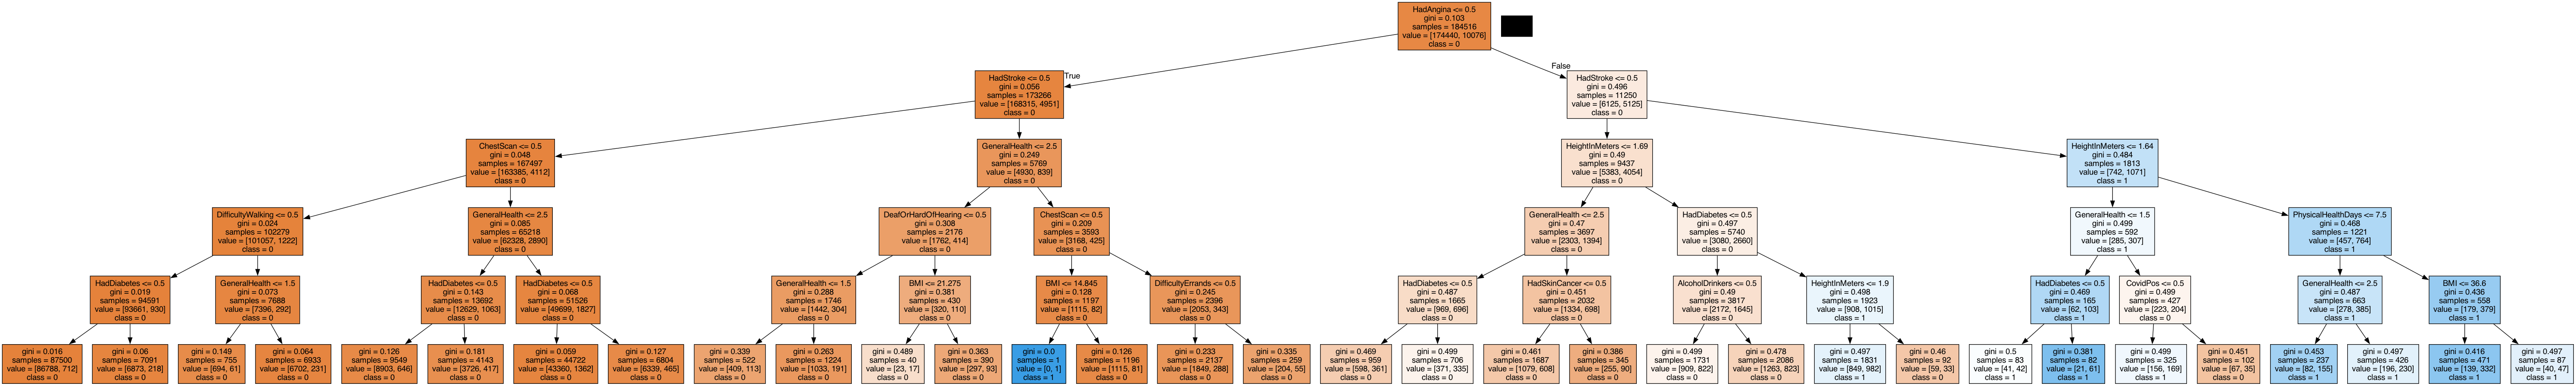

In [19]:
# Create DOT data
dot_data = tree.export_graphviz(
    model, out_file=None, feature_names=cleanHealth_df.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

In [20]:
text_representation = tree.export_text(model)
print(text_representation)

|--- feature_5 <= 0.50
|   |--- feature_6 <= 0.50
|   |   |--- feature_20 <= 0.50
|   |   |   |--- feature_17 <= 0.50
|   |   |   |   |--- feature_13 <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_13 >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_17 >  0.50
|   |   |   |   |--- feature_0 <= 1.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_0 >  1.50
|   |   |   |   |   |--- class: 0
|   |   |--- feature_20 >  0.50
|   |   |   |--- feature_0 <= 2.50
|   |   |   |   |--- feature_13 <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_13 >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- feature_0 >  2.50
|   |   |   |   |--- feature_13 <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_13 >  0.50
|   |   |   |   |   |--- class: 0
|   |--- feature_6 >  0.50
|   |   |--- feature_0 <= 2.50
|   |   |   |--- feature_14 <= 0.50
|   |   |   |   |--- feature_0 <= 1.50
|   |   |   |   |   |

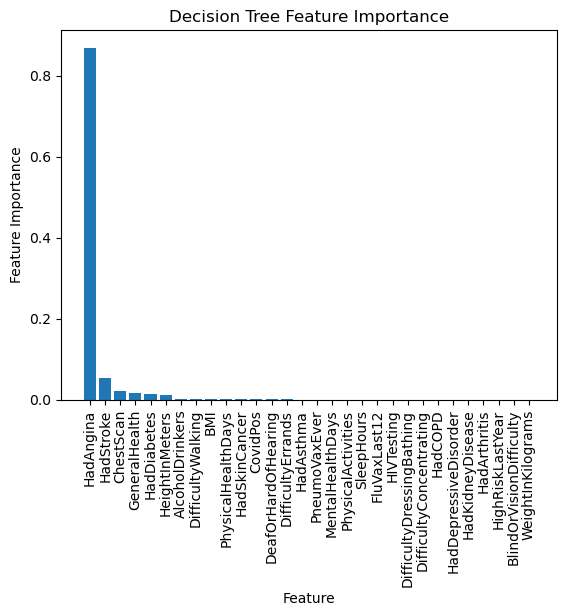

In [21]:
feature_importance = model.feature_importances_
feature_importance

#get feature names
feature_names = cleanHealth_df.columns  

# Sort feature importance
sorted_feat = np.argsort(feature_importance)[::-1]

# Plot  feature importance
plt.bar(range(X.shape[1]), feature_importance[sorted_feat])
plt.xticks(range(X.shape[1]), feature_names[sorted_feat], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Decision Tree Feature Importance')
plt.show()

In [22]:
model2 = tree.DecisionTreeClassifier(min_samples_leaf = 8)
model2 = model2.fit(X_train_scaled, y_train)
predictions2 = model2.predict(X_test_scaled)

In [23]:
# Calculating the confusion matrix
cm2 = confusion_matrix(y_test, predictions2)
cm_df2 = pd.DataFrame(
    cm2, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score2 = accuracy_score(y_test, predictions2)

# Displaying results
print("Confusion Matrix")
display(cm_df2)
print(f"Accuracy Score : {acc_score2}")
print("Classification Report")
print(classification_report(y_test, predictions2))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,57109,1038
Actual 1,2608,751


Accuracy Score : 0.9407212304490619
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     58147
           1       0.42      0.22      0.29      3359

    accuracy                           0.94     61506
   macro avg       0.69      0.60      0.63     61506
weighted avg       0.93      0.94      0.93     61506



In [24]:
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=500, max_depth=30, 
                                  random_state=42, min_samples_leaf = 1)
rf_model.fit(X_train, y_train)
predictions_rf = rf_model.predict(X_test)


In [25]:
# Calculating the confusion matrix
cm_rf = confusion_matrix(y_test, predictions_rf)
cm_df_rf = pd.DataFrame(
    cm_rf, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score_rf = accuracy_score(y_test, predictions_rf)

# Displaying results
print("Confusion Matrix")
display(cm_df_rf)
print(f"Accuracy Score : {acc_score_rf}")
print("Classification Report")
print(classification_report(y_test, predictions_rf))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,57720,427
Actual 1,2884,475


Accuracy Score : 0.9461678535427438
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     58147
           1       0.53      0.14      0.22      3359

    accuracy                           0.95     61506
   macro avg       0.74      0.57      0.60     61506
weighted avg       0.93      0.95      0.93     61506



In [26]:
dot_data = tree.export_graphviz(
    rf_model.estimators_[0], out_file=None, feature_names=cleanHealth_df.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())


KeyboardInterrupt



In [27]:
from sklearn import tree
import matplotlib.pyplot as plt



In [ ]:
fig = plt.figure(figsize=(100,15))
_ = tree.plot_tree(rf_model.estimators_[0],feature_names=cleanHealth_df.columns, class_names=["0", "1"],filled=True)

plt.savefig('test',dpi=500)

